# BSPF Event Analysis - Dispersion

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")

from obspy.core import read

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)
from twistpy.polarization import DispersionAnalysis
from twistpy.polarization.machinelearning import SupportVectorMachine

## Configurations

In [3]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

config['fmin'], config['fmax'] = 1.0, 17

## Load Data

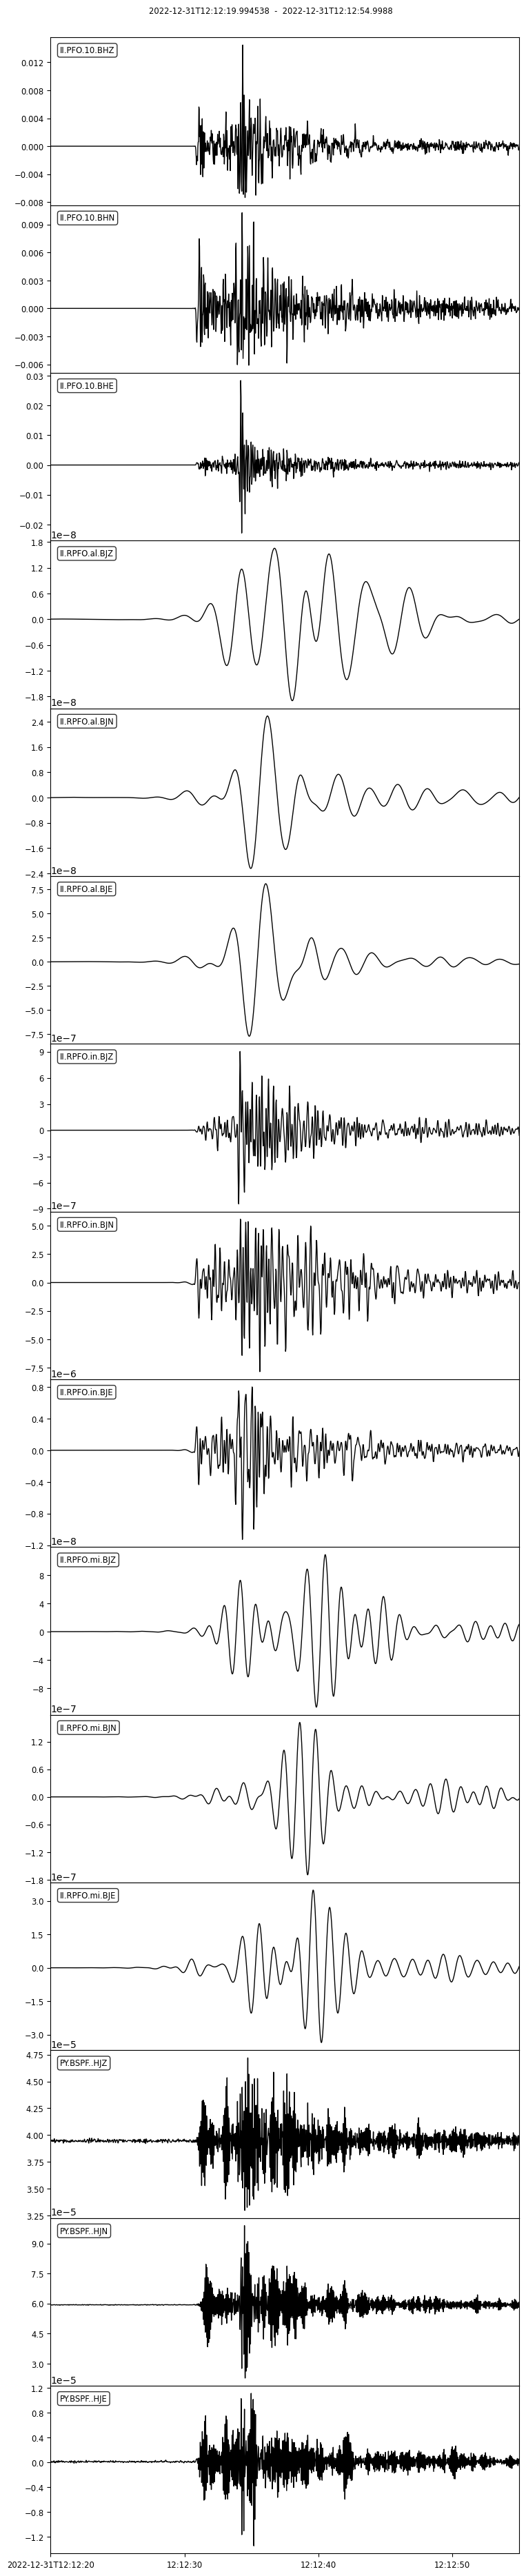

In [4]:
st = obs.read("./data/event42_6c.mseed")

tbeg = st[0].stats.starttime
tend = st[0].stats.endtime

st.plot(equal_scale=False);

## S-Transform

In [5]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [6]:
# fig = __makeplotStream_cwt(st, config);

## Dispersion

In [29]:
acc = st.select(station="PFO*").copy()
rot = st.select(station="BSPF").copy()

acc.detrend("demean").taper(0.05)
rot.detrend("demean").taper(0.05)

scaling_velocity = 1000 ##2000

for tr in acc:
    tr.data /= scaling_velocity

In [42]:
svm = SupportVectorMachine(name="dispersion_analysis2")

!rm /home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/dispersion_analysis2.pkl

svm.train(
            wave_types=["R", "L", "P", "SV", "Noise"],
            scaling_velocity=scaling_velocity,
            phi=(0, 360),
            vp=(400, 4000),
            vp_to_vs=(1.7, 2.2),
            vr=(100, 4000),
            vl=(100, 4000),
            xi=(-90, 90),
            theta=(0, 80),
            C=10,
            plot_confusion_matrix=False,
)

Generating random polarization models for training! 

Training Support Vector Machine!
Training successfully completed. Model score on independent test data is '0.9926'!
Model has been saved as '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/dispersion_analysis2.pkl'!'


In [48]:
da = DispersionAnalysis(
                        traN=acc.select(channel="*N")[0],
                        traE=acc.select(channel="*E")[0],
                        traZ=acc.select(channel="*Z")[0],
                        rotN=rot.select(channel="*N")[0],
                        rotE=rot.select(channel="*E")[0],
                        rotZ=rot.select(channel="*Z")[0],
                        window={"number_of_periods": 3, "overlap": 0.5},
                        scaling_velocity=scaling_velocity,
                        verbose=True,
                        fmin=1,
                        fmax=15.0,
                        octaves=0.25,
                        svm=svm,
)

Estimating surface wave parameters at frequency f =  15.00 Hz. Frequency step 1 out of 16.
Estimating surface wave parameters at frequency f =  12.61 Hz. Frequency step 2 out of 16.
Estimating surface wave parameters at frequency f =  10.61 Hz. Frequency step 3 out of 16.
Estimating surface wave parameters at frequency f =  8.92 Hz. Frequency step 4 out of 16.
Estimating surface wave parameters at frequency f =  7.50 Hz. Frequency step 5 out of 16.
Estimating surface wave parameters at frequency f =  6.31 Hz. Frequency step 6 out of 16.
Estimating surface wave parameters at frequency f =  5.30 Hz. Frequency step 7 out of 16.
Estimating surface wave parameters at frequency f =  4.46 Hz. Frequency step 8 out of 16.
Estimating surface wave parameters at frequency f =  3.75 Hz. Frequency step 9 out of 16.
Estimating surface wave parameters at frequency f =  3.15 Hz. Frequency step 10 out of 16.
Estimating surface wave parameters at frequency f =  2.65 Hz. Frequency step 11 out of 16.
Estim

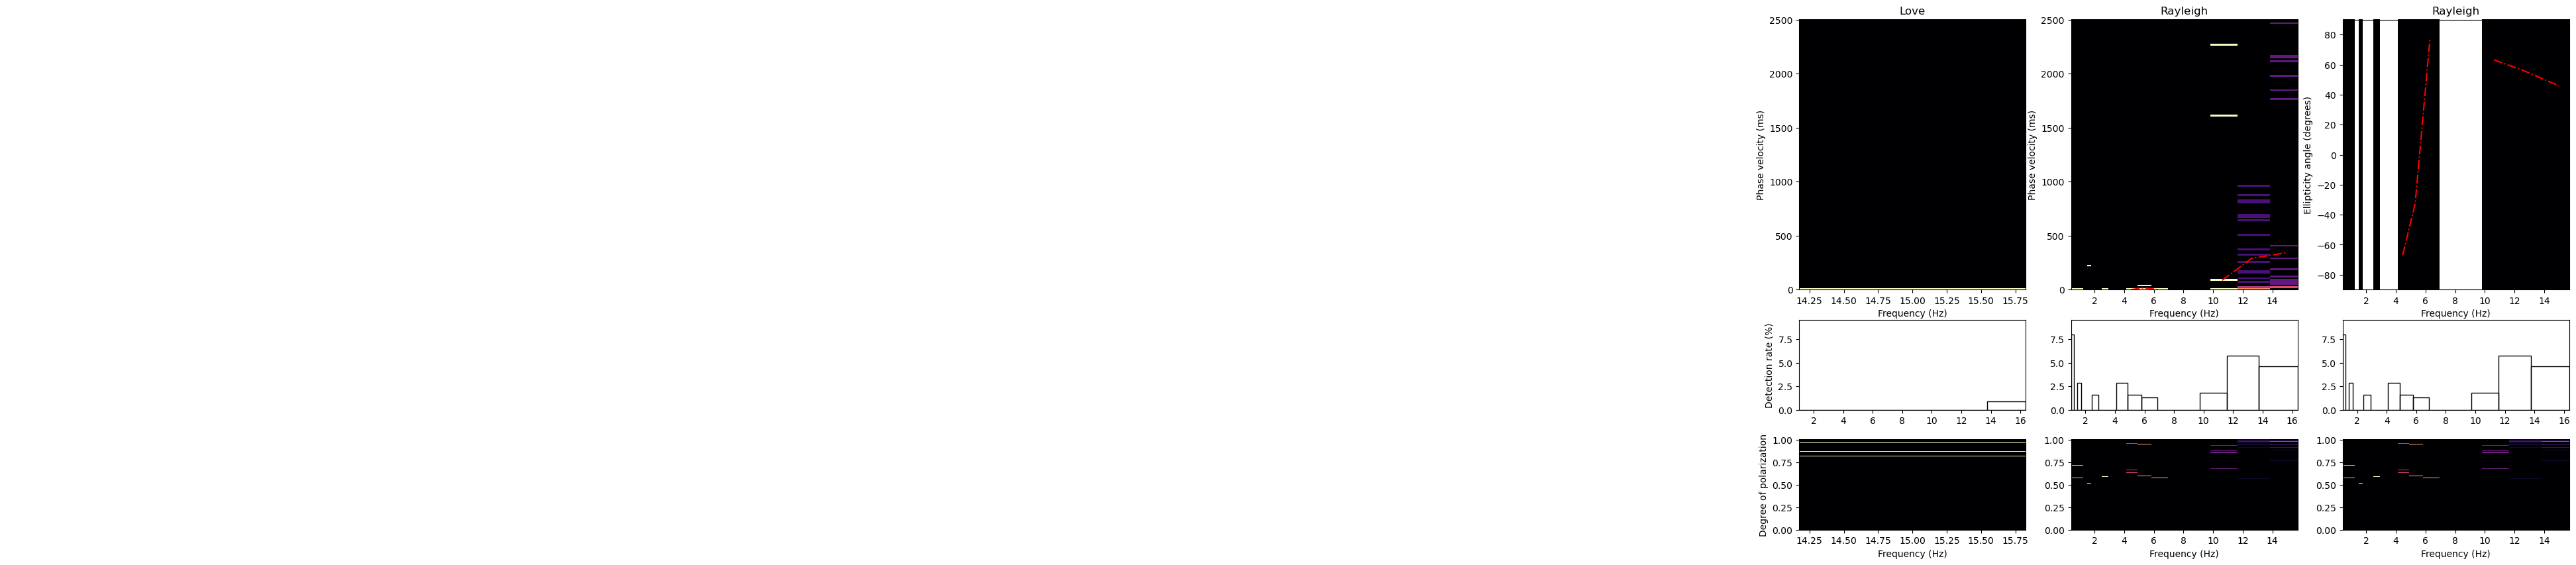

In [51]:
da.plot(nbins=150)

In [38]:
ff = da.f
cr = da.parameters[0]['c_r']

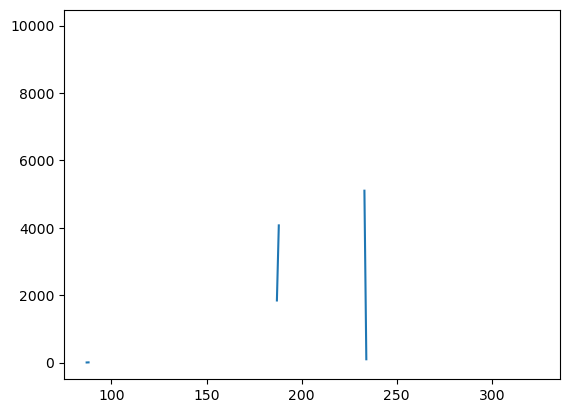

In [39]:
plt.plot(cr)

In [47]:
da.plot_baz(freq=10.0)

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 1500x600 with 2 Axes>

/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


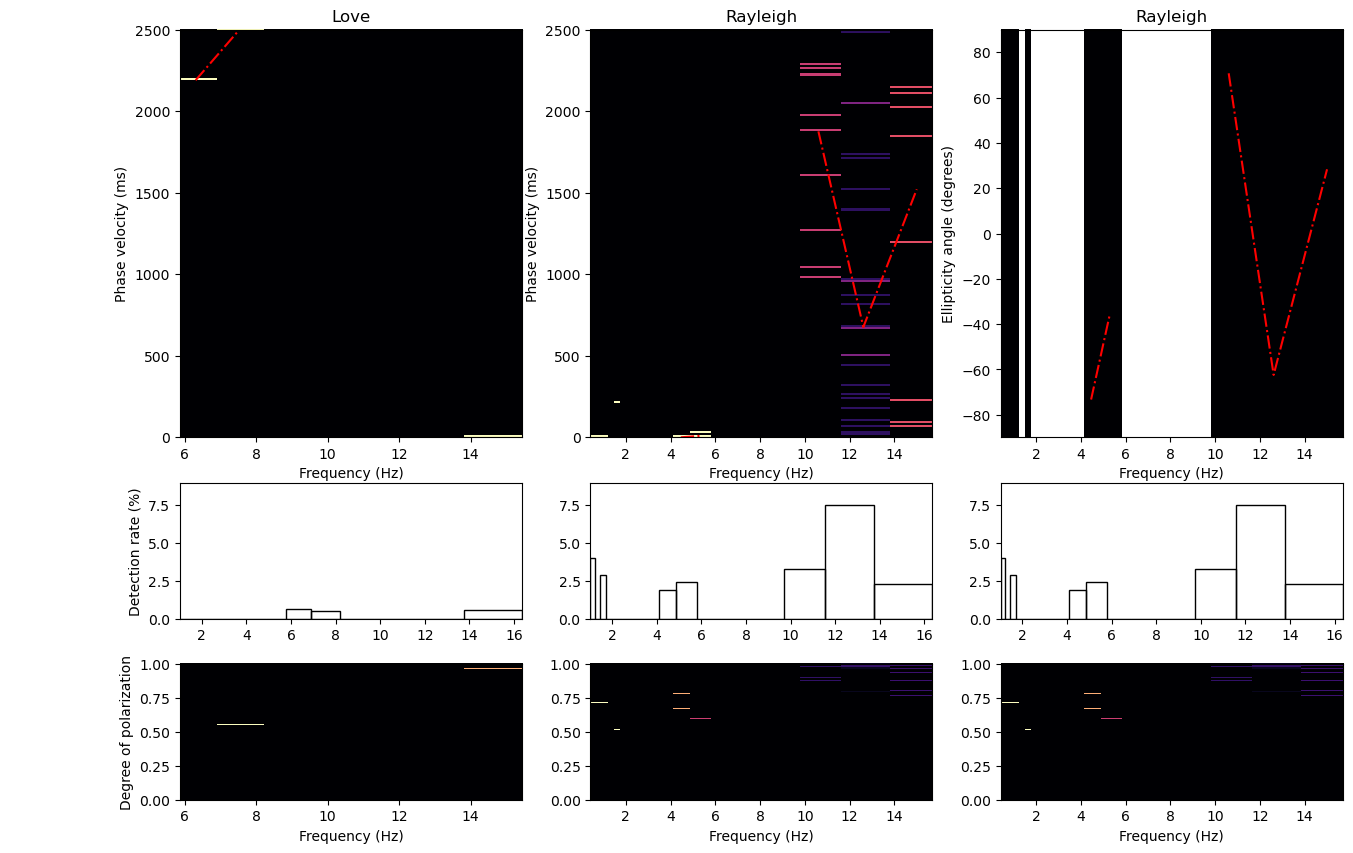

In [41]:
da.plot(nbins=200)